In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

def load_statistics(pointcloud_type, base_paths, scene_name, base_path_index):
    """
    Loads statistics from CSV files from multiple base paths.

    Args:
        pointcloud_type: The type of point cloud (e.g., 'lidar', 'mast3r').
        base_paths: A list of base directories where the CSV files are stored.
        scene_name: The name of the scene.
        base_path_index: The index of the base path in the base_paths list.

    Returns:
        A pandas DataFrame containing the loaded statistics, or None if no file is found.
    """
    dfs = []
    for base_path in base_paths:
        csv_file = os.path.join(base_path, f"{scene_name}_{pointcloud_type}.csv")
        print(f"Attempting to load: {csv_file}")  # Debugging print
        try:
            df = pd.read_csv(csv_file)
            df['base_path'] = base_path  # Add a column to identify the base path
            df['pointcloud_type'] = pointcloud_type  # Add a column to identify the pointcloud type
            df['model_number'] = base_path_index  # Add the model number
            dfs.append(df)
        except FileNotFoundError:
            print(f"Warning: CSV file not found for {pointcloud_type} at {csv_file}")

    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        return combined_df
    else:
        return None

# Define base paths and pointcloud types
BASE_PATHS = {
    "model_0": "results_finetuning/model_0",
    "model_1": "results_finetuning/spagna_train0_campus_train0",
    "model_2": "results_finetuning/ciampino_train0_ciampino_train1",
}
TYPES = ['mast3r', 'inliers_mast3r', 'lidar', 'mast3r_scaled_v4']
scene_name = "campus_train0"
loaded_data = {}

# Specify which results to load from which base path
result_specifications = {
    "mast3r_model_0": {"pointcloud_type": "mast3r", "base_path_key": "model_0"},
    "mast3r_model_1": {"pointcloud_type": "mast3r", "base_path_key": "model_1"},
    "mast3r_model_2": {"pointcloud_type": "mast3r", "base_path_key": "model_2"},
    "inliers_mast3r_model_1": {"pointcloud_type": "inliers_mast3r", "base_path_key": "model_1"},
    "inliers_mast3r_model_2": {"pointcloud_type": "inliers_mast3r", "base_path_key": "model_2"},
    "lidar_model_0": {"pointcloud_type": "lidar", "base_path_key": "model_0"},
    "mast3r_scaled_v4_model_0": {"pointcloud_type": "mast3r_scaled_v4", "base_path_key": "model_0"}
}

for new_key, spec in result_specifications.items():
    pointcloud_type = spec["pointcloud_type"]
    base_path_key = spec["base_path_key"]
    base_path = BASE_PATHS[base_path_key]
    base_path_index = list(BASE_PATHS.keys()).index(base_path_key)  # Get index from key order

    df = load_statistics(pointcloud_type, [base_path], scene_name=scene_name, base_path_index=base_path_index)
    if df is not None:
        # Convert numeric columns
        numeric_columns = ["n_matches", "n_inliers", "n_overlapping", "median_depth",
                           "x_error", "y_error", "z_error", "pos_error", "rot_error",
                           "distance_anchor_query", "pointmap_error_x", "pointmap_error_y", "pointmap_error_z"]

        scale_cols = [col for col in df.columns if col.startswith("scale")]
        numeric_columns.extend(scale_cols)

        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

        print(f"Creating key: {new_key}")  # Debugging print
        loaded_data[new_key] = df
    else:
        print(f"No data loaded for {pointcloud_type} in {base_path}")  # Debugging print

Attempting to load: results_finetuning/model_0/campus_train0_mast3r.csv
Creating key: mast3r_model_0
Attempting to load: results_finetuning/spagna_train0_campus_train0/campus_train0_mast3r.csv
Creating key: mast3r_model_1
Attempting to load: results_finetuning/ciampino_train0_ciampino_train1/campus_train0_mast3r.csv
Creating key: mast3r_model_2
Attempting to load: results_finetuning/spagna_train0_campus_train0/campus_train0_inliers_mast3r.csv
Creating key: inliers_mast3r_model_1
Attempting to load: results_finetuning/ciampino_train0_ciampino_train1/campus_train0_inliers_mast3r.csv
Creating key: inliers_mast3r_model_2
Attempting to load: results_finetuning/model_0/campus_train0_lidar.csv
Creating key: lidar_model_0
Attempting to load: results_finetuning/model_0/campus_train0_mast3r_scaled_v4.csv
Creating key: mast3r_scaled_v4_model_0


/tmp/ipykernel_1873582/1495568204.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)


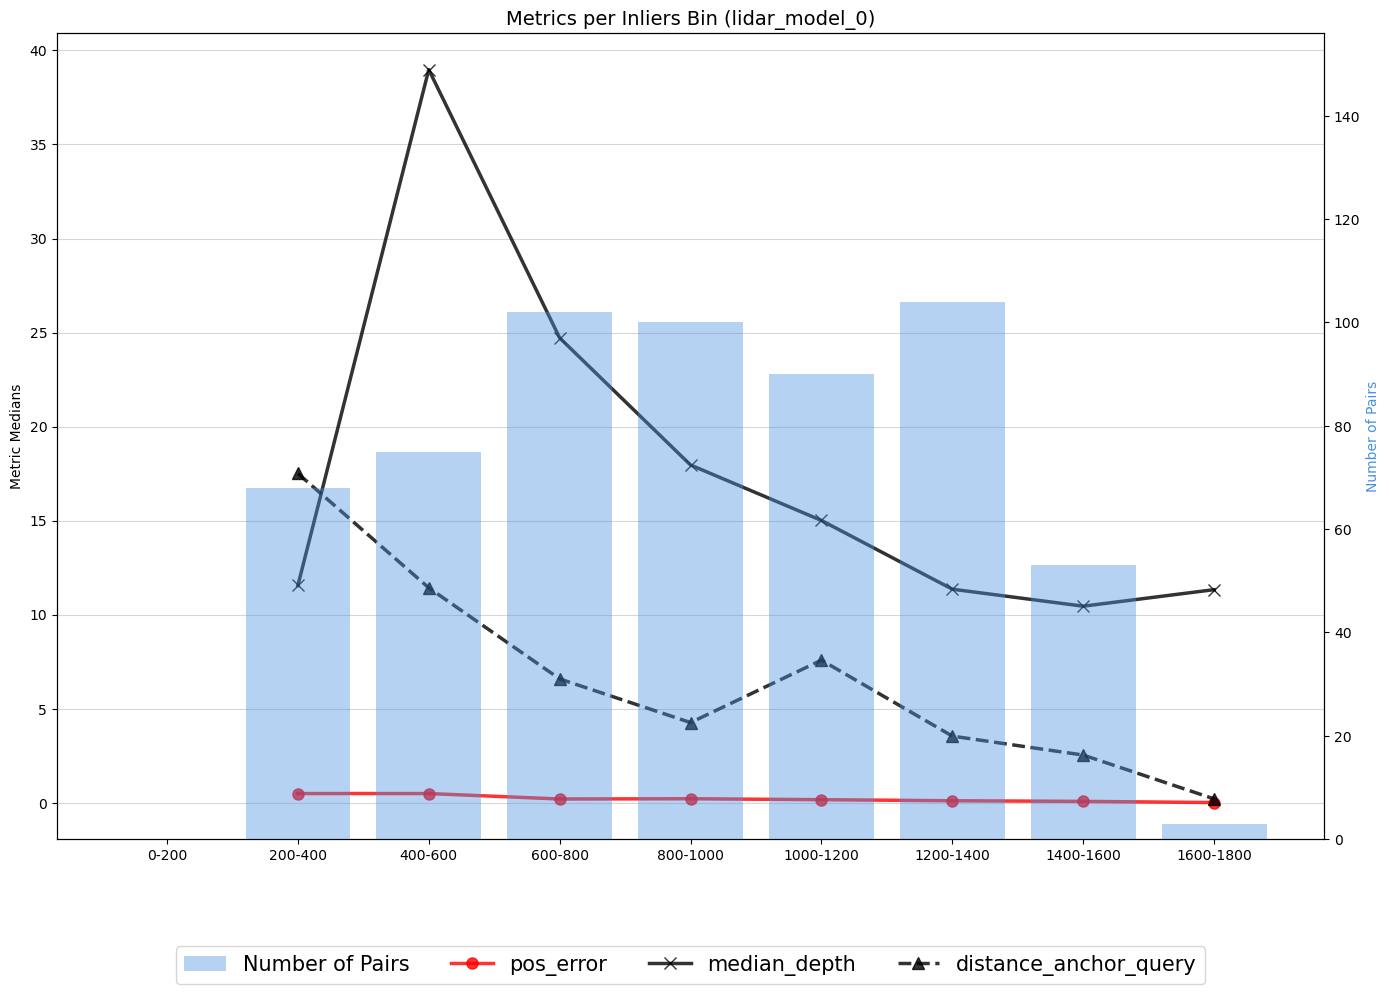

In [2]:
def plot_metrics_per_bin(dataset_to_plot, bin_by, metrics_to_plot, annotation_metrics, bin_min=None, bin_max=None):
    """
    Plot metrics per bin for a specific dataset, including bar plots for pair counts
    and line plots for metric medians, with optional custom bin limits.

    Args:
        dataset_to_plot: Name of the dataset to plot (e.g., 'mast3r_model_0').
        bin_by: Column name to bin by (e.g., 'num_inliers' or 'num_matches').
        metrics_to_plot: Dictionary of metrics to plot with their configurations.
        annotation_metrics: List of metrics to annotate on the bar plot.
        bin_min: Minimum bin limit (default: None, uses data minimum).
        bin_max: Maximum bin limit (default: None, uses data maximum).
    """
    if dataset_to_plot not in loaded_data:
        print(f"Error: Dataset '{dataset_to_plot}' not found in loaded_data.")
        return

    df = loaded_data[dataset_to_plot]
    df_ok = df[df['status'] == 'OK']

    # Determine bin limits
    data_min = df_ok[bin_by].min()
    data_max = df_ok[bin_by].max()
    bin_min = bin_min if bin_min is not None else 0
    bin_max = bin_max if bin_max is not None else int(data_max) + BIN_WIDTH

    # Create bins based on the selected binning column and custom limits
    bins = range(bin_min, bin_max, BIN_WIDTH)
    bin_column = f"{bin_by}_bin"
    df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)

    # Group by the bins and compute statistics
    grouped = df_ok.groupby(bin_column)
    count_by_bin = grouped.size()

    # Compute median for annotation metrics
    annotation_medians = {metric: grouped[metric].median() for metric in annotation_metrics if metric in df_ok.columns}

    # Compute median for each selected metric to plot
    metric_medians = {metric: grouped[metric].median() for metric in metrics_to_plot.keys() if metric in df_ok.columns}

    # Convert bin intervals to numeric values (midpoints)
    bin_midpoints = [interval.mid for interval in count_by_bin.index]

    # Create the plot
    fig, ax2 = plt.subplots(figsize=(14, 10))
    ax1 = ax2.twinx()
    # Bar plot: number of pairs per bin (left y-axis)
    bars = ax1.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=BIN_WIDTH * 0.8, alpha=0.4, label="Number of Pairs")
    ax1.set_ylabel("Number of Pairs", color="#4A90E2")
    ax1.set_xlabel(f"{bin_by} (binned)")
    ax1.set_xticks(bin_midpoints)
    ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in count_by_bin.index], rotation=45, ha="right")
    ax1.set_ylim(0, max(count_by_bin) * 1.5)

    # # Annotate bars with median values of selected metrics
    # for i, bar in enumerate(bars):
    #     annotation_text = [f"{metric}:{annotation_medians[metric].iloc[i]:.0f}" for metric in annotation_metrics if metric in annotation_medians]
    #     if annotation_text:
    #         ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + max(count_by_bin) * 0.02, " \n ".join(annotation_text), ha="center", va="bottom", fontsize=9, color="#2C3E50", weight="bold")

    # Add line plots for metric medians (right y-axis)
    ax2.set_ylabel("Metric Medians", color="black")
    line_plots = []
    for metric, config in metrics_to_plot.items():
        if metric in metric_medians:
            line = ax2.plot(bin_midpoints, metric_medians[metric],
                            color=config['color'], marker=config['marker'],
                            label=config['label'], linewidth=2.5, linestyle=config['linestyle'], markersize=8, alpha=0.8)
            line_plots.append((line[0], config['label']))

    # Combine legends
    legend_items = [(bars, "Number of Pairs")] + line_plots
    handles, labels = zip(*legend_items)
    ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=min(len(handles), 4), fontsize=15)

    # Add grid lines
    ax2.grid(axis="y", linestyle="-", alpha=0.5)
    # ax2.grid(axis="y", linestyle=".", alpha=0.3)
    # Dynamic title based on binning variable
    bin_label = "Matches" if bin_by == 'num_matches' else "Inliers"
    plt.title(f"Metrics per {bin_label} Bin ({dataset_to_plot})", fontsize=14)  # Include dataset_to_plot in the title
    plt.tight_layout()
    plt.show()
BIN_WIDTH = 200

# Example usage with custom bin limits
plot_metrics_per_bin(
    dataset_to_plot='lidar_model_0',  # Plot mast3r from the first base path
    bin_by='n_inliers',
    metrics_to_plot={
        'pos_error': {'color': 'red', 'marker': 'o', 'linestyle': '-', 'label': "pos_error"},
        'median_depth': {'color': 'black', 'marker': 'x', 'linestyle': '-', 'label': 'median_depth'},
        'distance_anchor_query': {'color': 'black', 'marker': '^', 'linestyle': '--', 'label': 'distance_anchor_query'},
    },
    annotation_metrics=['n_inliers', 'n_overlapping'],
    bin_min=None,  # Custom minimum bin limit
    bin_max=None  # Custom maximum bin limit
)

In [3]:
# Table 1: Success rate and num_inliers (median)
table1_data = []
for pointcloud_type, df in loaded_data.items():  # Iterate through the new keys
    ok_pairs = df[df['status'] == 'OK']
    table1_data.append({
        'method': pointcloud_type,  # Use the combined name as the method
        'n_success': len(ok_pairs),
        'n_total': len(df),
        'success_rate': len(ok_pairs) / len(df) if len(df) > 0 else 0,
        'num_inliers_median': ok_pairs['n_inliers'].median() if len(ok_pairs) > 0 else np.nan
    })

table1 = pd.DataFrame(table1_data)
print("Table 1: Success Rates and Inliers")
print(table1)
print()

# Table 2: Position and rotation errors (median)
table2_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    table2_data.append({
        'method': pointcloud_type,
        'pos_error_median': ok_pairs['pos_error'].median() if len(ok_pairs) > 0 else np.nan,
        'x_error_median': ok_pairs['x_error'].median() if len(ok_pairs) > 0 else np.nan,
        'y_error_median': ok_pairs['y_error'].median() if len(ok_pairs) > 0 else np.nan,
        'z_error_median': ok_pairs['z_error'].median() if len(ok_pairs) > 0 else np.nan,
        'rot_error_median': ok_pairs['rot_error'].median() if len(ok_pairs) > 0 else np.nan
    })

table2 = pd.DataFrame(table2_data)
print("Table 2: Position and Rotation Errors (Median)")
print(table2.to_string(index=False))
print()

# Table 3: Distance and scales (mean and median)
table3_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']

    row = {
        'method': pointcloud_type,
        'distance_mean': ok_pairs['median_depth'].mean() if 'median_depth' in ok_pairs.columns and len(ok_pairs) > 0 else np.nan,
        'distance_median': ok_pairs['median_depth'].median() if 'median_depth' in ok_pairs.columns and len(ok_pairs) > 0 else np.nan,
    }

    # Add scale statistics
    if 'scale' in ok_pairs.columns:
        # row['scale_mean'] = ok_pairs['scale'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_median'] = ok_pairs['scale'].median() if len(ok_pairs) > 0 else np.nan

    if 'scale_x' in ok_pairs.columns:
        # row['scale_x_mean'] = ok_pairs['scale_x'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_x_median'] = ok_pairs['scale_x'].median() if len(ok_pairs) > 0 else np.nan

    if 'scale_y' in ok_pairs.columns:
        # row['scale_y_mean'] = ok_pairs['scale_y'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_y_median'] = ok_pairs['scale_y'].median() if len(ok_pairs) > 0 else np.nan

    if 'scale_z' in ok_pairs.columns:
        # row['scale_z_mean'] = ok_pairs['scale_z'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_z_median'] = ok_pairs['scale_z'].median() if len(ok_pairs) > 0 else np.nan

    table3_data.append(row)

table3 = pd.DataFrame(table3_data)
print("Table 3: Distance and Scale Statistics")
print(table3.to_string(index=False))

Table 1: Success Rates and Inliers
                     method  n_success  n_total  success_rate  \
0            mast3r_model_0        595      613      0.970636   
1            mast3r_model_1        595      613      0.970636   
2            mast3r_model_2        595      613      0.970636   
3    inliers_mast3r_model_1        595      613      0.970636   
4    inliers_mast3r_model_2        595      613      0.970636   
5             lidar_model_0        595      613      0.970636   
6  mast3r_scaled_v4_model_0        595      613      0.970636   

   num_inliers_median  
0               901.0  
1               901.0  
2               901.0  
3               901.0  
4               901.0  
5               901.0  
6               901.0  

Table 2: Position and Rotation Errors (Median)
                  method  pos_error_median  x_error_median  y_error_median  z_error_median  rot_error_median
          mast3r_model_0          2.342295        0.312928        0.109746        2.234179     

In [4]:
import logging
print(logging.__version__)

0.5.1.2


/tmp/ipykernel_1873582/1859170874.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_1873582/1859170874.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_1873582/1859170874.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

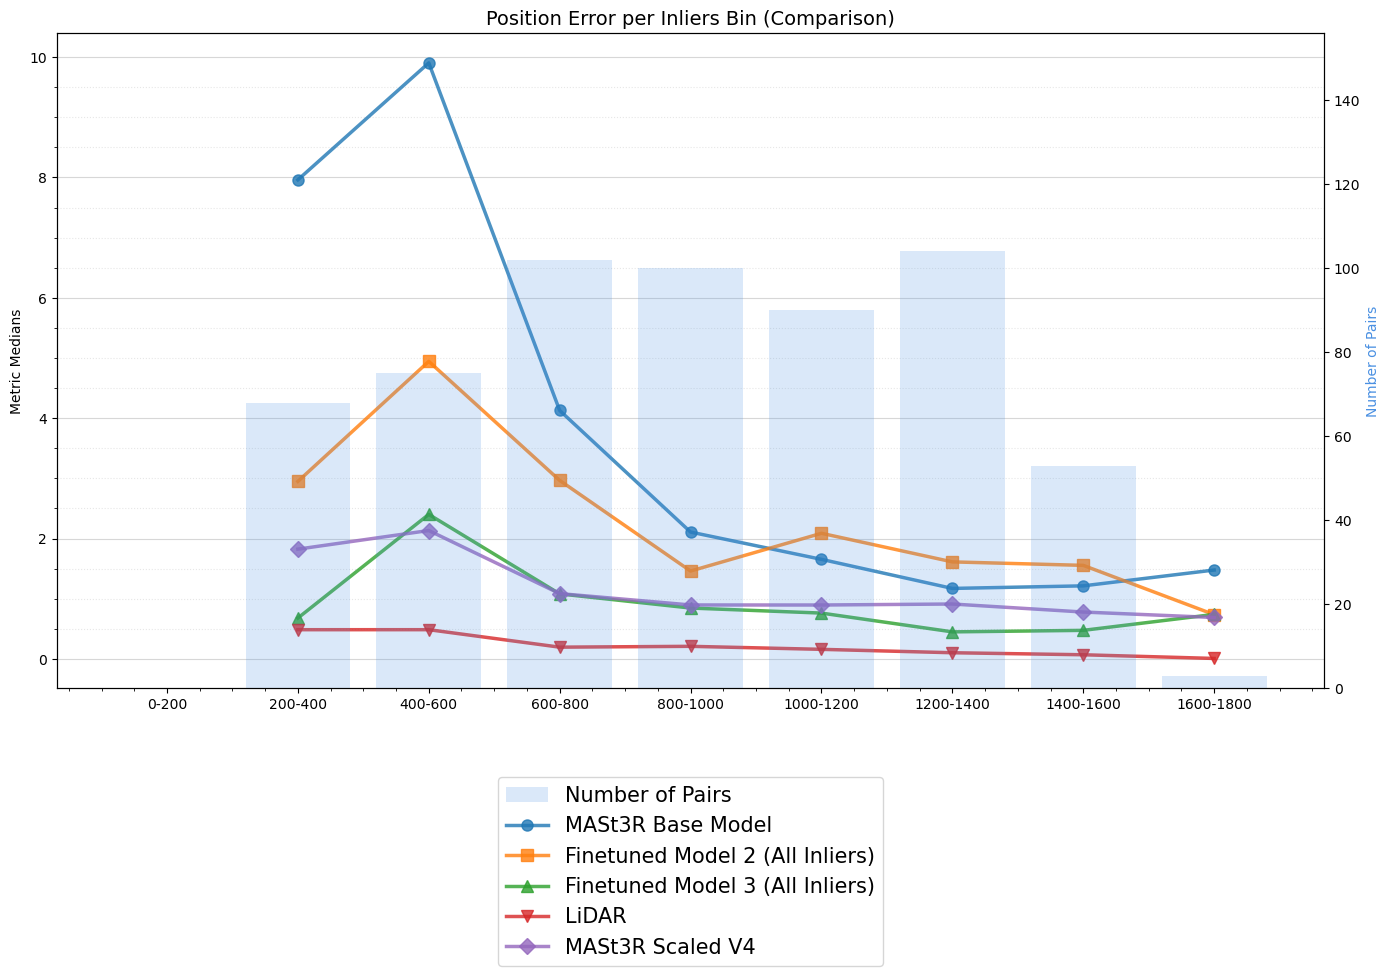

/tmp/ipykernel_1873582/1859170874.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_1873582/1859170874.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_1873582/1859170874.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

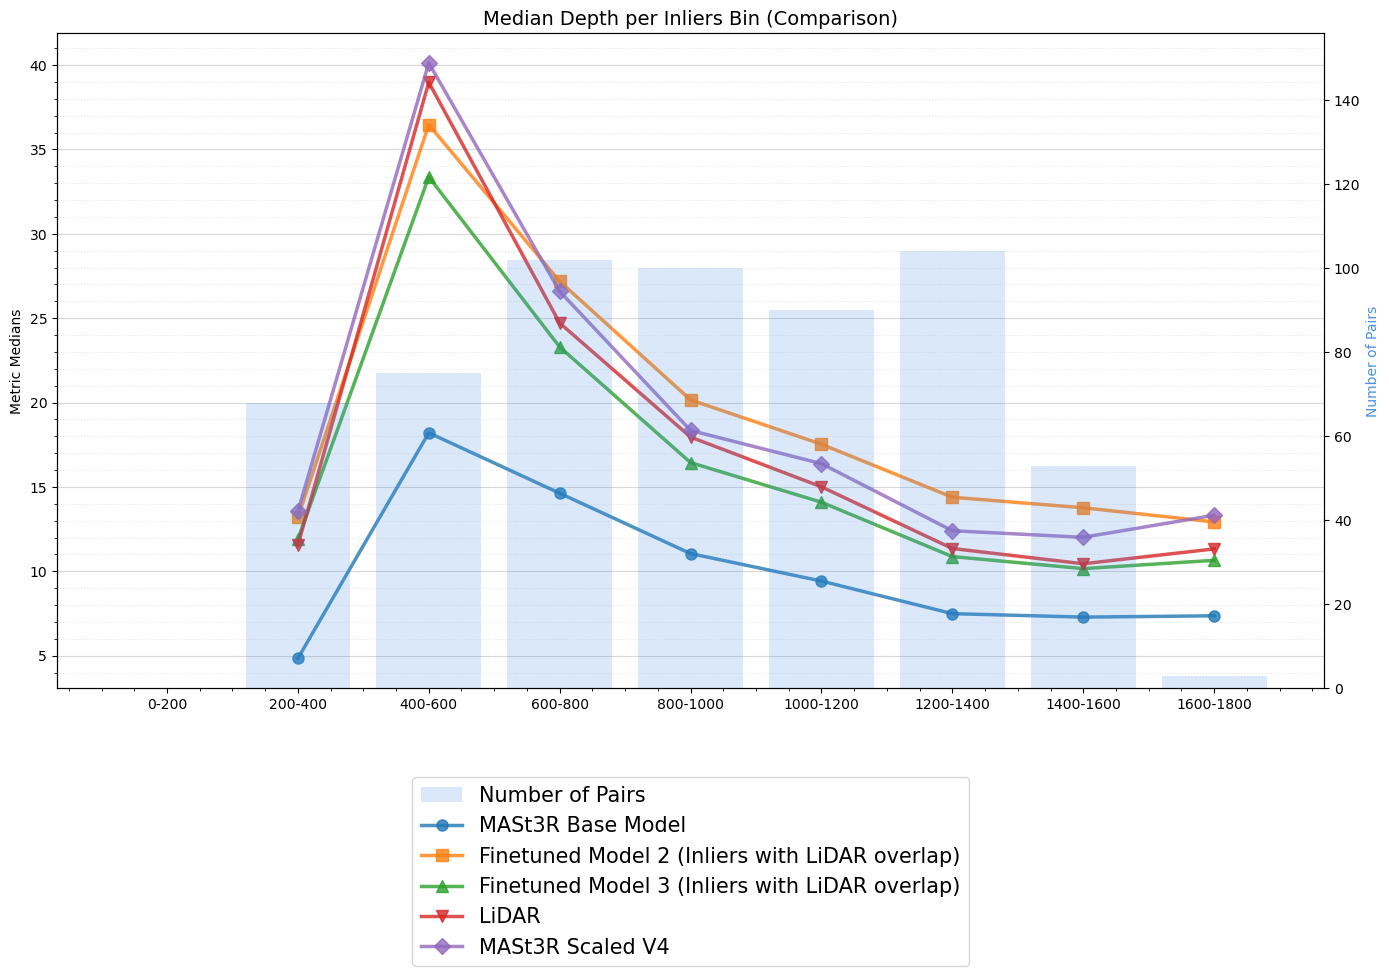

In [7]:
def compare_metrics_per_bin_custom_legend(
    dataset_names, bin_by, metrics_to_plot, annotation_metrics,
    dataset_legends, bin_min=None, bin_max=None
):
    fig, ax2 = plt.subplots(figsize=(14, 10))
    ax1 = ax2.twinx()
    colors = [
        '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
        '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
        '#bcbd22', '#17becf'
    ]
    markers = [
        'o', 's', '^', 'v', 'D', 'P', '*', 'X', '<', '>'
    ]
    legend_items = []
    bars = None

    for i, dataset_to_plot in enumerate(dataset_names):
        if dataset_to_plot not in loaded_data:
            print(f"Error: Dataset '{dataset_to_plot}' not found in loaded_data.")
            continue
        df = loaded_data[dataset_to_plot]
        df_ok = df[df['status'] == 'OK']

        data_min = df_ok[bin_by].min()
        data_max = df_ok[bin_by].max()
        bin_min_val = bin_min if bin_min is not None else 0
        bin_max_val = bin_max if bin_max is not None else int(data_max) + BIN_WIDTH
        bins = range(bin_min_val, bin_max_val, BIN_WIDTH)
        bin_column = f"{bin_by}_bin"
        df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)

        grouped = df_ok.groupby(bin_column)
        count_by_bin = grouped.size()
        metric_medians = {metric: grouped[metric].median() for metric in metrics_to_plot.keys() if metric in df_ok.columns}
        bin_midpoints = [interval.mid for interval in count_by_bin.index]

        if i == 0:
            bars = ax1.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=BIN_WIDTH * 0.8, alpha=0.2, label="Number of Pairs")
            ax1.set_ylabel("Number of Pairs", color="#4A90E2")
            ax1.set_xlabel(f"{bin_by} (binned)")
            ax1.set_xticks(bin_midpoints)
            ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in count_by_bin.index], rotation=45, ha="right")
            ax1.set_ylim(0, max(count_by_bin) * 1.5)
            legend_items.append((bars, "Number of Pairs"))

        ax2.minorticks_on()
        ax2.grid(which="minor", axis="y", linestyle=":", alpha=0.3)
        ax2.set_ylabel("Metric Medians", color="black")

        for metric, config in metrics_to_plot.items():
            if metric in metric_medians:
                line = ax2.plot(
                    bin_midpoints, metric_medians[metric],
                    color=colors[i % len(colors)], marker=markers[i % len(markers)],
                    label=f"{dataset_legends[i]} - {config['label']}",
                    linewidth=2.5, linestyle=config['linestyle'], markersize=8, alpha=0.8
                )
                legend_items.append((line[0], f"{dataset_legends[i]}"))

    handles, labels = zip(*legend_items)
    ncol_val = min(len(handles), 1)
    ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=ncol_val, fontsize=15)
    ax2.grid(axis="y", linestyle="-", alpha=0.5)

    if len(metrics_to_plot) == 1:
        metric_label = list(metrics_to_plot.values())[0]['label']
    else:
        metric_label = ", ".join([config['label'] for config in metrics_to_plot.values()])
    bin_label = "Matches" if bin_by == 'num_matches' else "Inliers"
    plt.title(f"{metric_label} per {bin_label} Bin (Comparison)", fontsize=14)
    plt.tight_layout()
    plt.show()
    
compare_metrics_per_bin_custom_legend(
    dataset_names=['mast3r_model_0', 'inliers_mast3r_model_1', 'inliers_mast3r_model_2', 'lidar_model_0', "mast3r_scaled_v4_model_0"],
    bin_by='n_inliers',
    metrics_to_plot={
        'pos_error': {'color': 'red', 'marker': 'o', 'linestyle': '-', 'label': "Position Error"},
    },
    annotation_metrics=['n_inliers', 'n_overlapping'],
    dataset_legends=['MASt3R Base Model', 'Finetuned Model 2 (All Inliers)', 'Finetuned Model 3 (All Inliers)', 'LiDAR',"MASt3R Scaled V4"],
    bin_min=None,
    bin_max=None
)

compare_metrics_per_bin_custom_legend(
    dataset_names=['mast3r_model_0', 'mast3r_model_1', 'mast3r_model_2', 'lidar_model_0','mast3r_scaled_v4_model_0'],
    bin_by='n_inliers',
    metrics_to_plot={
        'median_depth': {'color': 'red', 'marker': 'o', 'linestyle': '-', 'label': "Median Depth"},
    },
    annotation_metrics=['n_inliers', 'n_overlapping'],
    dataset_legends=['MASt3R Base Model','Finetuned Model 2 (Inliers with LiDAR overlap)', 'Finetuned Model 3 (Inliers with LiDAR overlap)', 'LiDAR', 'MASt3R Scaled V4'],
    bin_min=None,
    bin_max=None
)


/tmp/ipykernel_1873582/4245104213.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mast3r_ok[bin_column] = pd.cut(df_mast3r_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_1873582/4245104213.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mast3r_ok[bin_column] = pd.cut(df_mast3r_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_1873582/4245104213.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

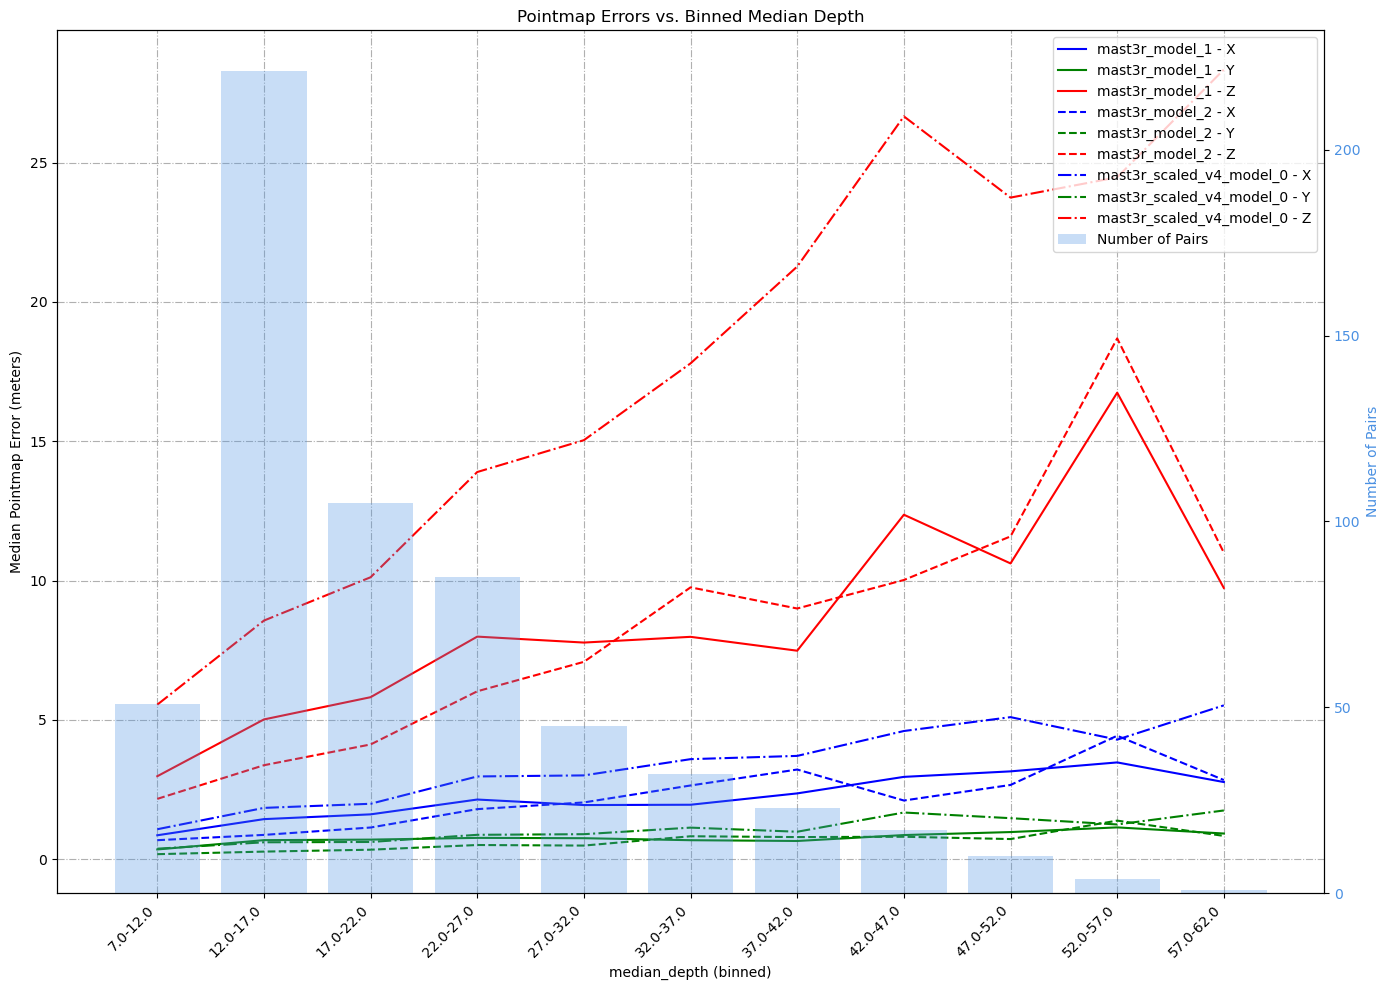

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_pointmap_errors_per_bin(dataset_names, bin_width=5):
    """
    Plot median pointmap errors per bin of median depth for multiple mast3r datasets,
    with a bar plot showing the number of data points per bin (from the first dataset).

    Args:
        dataset_names: A list of dataset names to plot (e.g., ['mast3r_model_0', 'mast3r_model_1']).
        bin_width: The width of the bins for median depth.
    """
    fig, ax1 = plt.subplots(figsize=(14, 10))
    ax2 = ax1.twinx()  # Create a twin Axes sharing the x-axis

    # Define colors and markers for each dataset
    # Define colors for x, y, and z errors
    colors = {'x': 'blue', 'y': 'green', 'z': 'red'}
    # Define line styles for the two datasets
    linestyles = ['-', '--', '-.']  # Ensure there are enough linestyles

    # Store bin midpoints and counts for the first dataset (for the bar plot)
    bin_midpoints = None
    count_by_bin = None
    bins_used = None  # Store the bins used for the first dataset

    for i, dataset_name in enumerate(dataset_names):
        if dataset_name not in loaded_data:
            print(f"Error: Dataset '{dataset_name}' not found in loaded_data.")
            continue

        df_mast3r = loaded_data[dataset_name]
        df_mast3r_ok = df_mast3r[df_mast3r['status'] == 'OK']

        # Check if required columns are available
        required_columns = ['median_depth', 'pointmap_error_x', 'pointmap_error_y', 'pointmap_error_z']
        missing_columns = [col for col in required_columns if col not in df_mast3r_ok.columns]

        if missing_columns:
            print(f"Error: Missing required columns in {dataset_name} data: {missing_columns}")
            continue

        # Configuration
        bin_by = 'median_depth'
        bin_min = df_mast3r_ok[bin_by].min()
        bin_max = df_mast3r_ok[bin_by].max()

        # Create bins
        bins = range(int(bin_min), int(bin_max) + bin_width, bin_width)
        bin_column = f"{bin_by}_bin"
        df_mast3r_ok[bin_column] = pd.cut(df_mast3r_ok[bin_by], bins=bins, right=False)

        # Group by bin
        grouped = df_mast3r_ok.groupby(bin_column)

        # Calculate median pointmap errors per bin
        pointmap_error_x_median = grouped['pointmap_error_x'].median()
        pointmap_error_y_median = grouped['pointmap_error_y'].median()
        pointmap_error_z_median = grouped['pointmap_error_z'].median()

        # Store bin information from the FIRST dataset
        if i == 0:
            bin_midpoints = [interval.mid for interval in grouped.size().index]
            count_by_bin = grouped.size()
            bins_used = bins  # Store the bins

            # Bar plot: number of pairs per bin (right y-axis)
            ax2.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=bin_width * 0.8, alpha=0.3,
                    label="Number of Pairs")
            ax2.set_ylabel("Number of Pairs", color="#4A90E2")
            ax2.tick_params(axis="y", labelcolor="#4A90E2")

            # Customize x-axis ticks and labels to show bin ranges
            bin_labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins)-1)]
            ax1.set_xticks(bin_midpoints)
            ax1.set_xticklabels(bin_labels, rotation=45, ha='right')
        
        # Plot Pointmap Errors vs. Binned Metric (on the left y-axis)
        # Ensure that the lengths of bin_midpoints and pointmap_error_x_median.values are the same
        
        # Reindex the pointmap errors to match the bin midpoints
        pointmap_error_x_median = pointmap_error_x_median.reindex(bin_midpoints)
        pointmap_error_y_median = pointmap_error_y_median.reindex(bin_midpoints)
        pointmap_error_z_median = pointmap_error_z_median.reindex(bin_midpoints)

        linestyle = linestyles[i % len(linestyles)]  # Cycle through line styles

        ax1.plot(bin_midpoints, pointmap_error_x_median.values, color=colors['x'], linestyle=linestyle,
                label=f'{dataset_name} - X')
        ax1.plot(bin_midpoints, pointmap_error_y_median.values, color=colors['y'], linestyle=linestyle,
                label=f'{dataset_name} - Y')
        ax1.plot(bin_midpoints, pointmap_error_z_median.values, color=colors['z'], linestyle=linestyle,
                label=f'{dataset_name} - Z')

    ax1.set_xlabel(f'{bin_by} (binned)')
    ax1.set_ylabel('Median Pointmap Error (meters)')
    ax1.set_title(f'Pointmap Errors vs. Binned Median Depth')

    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    ax1.grid(True, linestyle='-.')
    fig.tight_layout()
    plt.show()

# Example Usage:
# Assuming you have loaded 'mast3r_model_0' and 'mast3r_model_1'
datasets_to_compare = ['mast3r_model_1', 'mast3r_model_2', 'mast3r_scaled_v4_model_0']  # Add more mast3r datasets
compare_pointmap_errors_per_bin(datasets_to_compare)